# Exploratory Analysis/Visualizations 
Many of these graphs appear in the UI "Top Movies Visualizations" section    
Some are just to answer questions to inform modeling 

- Metadata Frequency distributions
    - Genres
    - Genre combinations
    - Release year
    - Filming countries
    - Actors
    - Directors
    - Production Companies
    - Description Tokens
- Genome Tags
    - Genome Tag Relevance
    - Common Tags
    - Number of Tags per Movie
- Ratings 
    - Year of review
        - Many old reviews. May want to to downweight older reviews
    - Number of ratings per movie
        - Many movies in long tail (58% of movies with fewer than 10 ratings)
        - Collaborative filtering approaches will miss a large percent of the catalog
        - Want to expose long tail to increase overall streaming 
    - Distribution of star ratings (0.5-5)
        - Positively skewed
        - Should normalize ratings by user 
- Most highly rated 
    - Two versions: (1) Top average rating if > 100 ratings (2) Weighted average between average rating and count
        - If just sort by average rating, get lots of 5 star movies that have only been rated once or twice
        - For version 1, base off of movies that have at least 100 ratings. Else taking average of averages of small numbers (ex highest rated actors is an average of the average rating of each movie they have acted in)
        - For version 2, base off of all movies because weighting by count
    - Genre, actor, director, country, decade, production company
- Distribution of ratings counts by genome tag presence
    - Genome tags largely only present for popular movies with many ratings 
    - Models based on tags will largely ignore the long tail 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import operator
import fastparquet
import pickle
import math

## Load Data: created in recommendation data exploration

In [2]:
df = pd.read_parquet('processed_files/movies_processed.parq')
movie_ratings  = pd.read_parquet('processed_files/movies_ratings.parq')
ratings = pd.read_parquet('processed_files/ratings_sample.parq')

In [3]:
tags = pd.read_csv('data/ml-25m/genome-tags.csv')
relevance = pd.read_csv('data/ml-25m/genome-scores.csv')

# merge tags and relevance scores
tags = pd.merge(tags, relevance, on = 'tagId')

# exclude movies not in main df
tags = tags[tags.movieId.isin(df.movieId.unique())]

## Get Counts of each Value

In [4]:
def cat_list_expand(df, var):
    
    # expand lists such that one entry per row 
    expanded = df[[var, 'movieId']]
    expanded = pd.DataFrame({
        col:np.repeat(expanded[col].values, expanded[var].str.len()) for col in expanded.columns.drop(var)}
    ).assign(**{var:np.concatenate(expanded[var].values)})[expanded.columns]

    return expanded

In [5]:
def delimited_count(df, var, new_var):
    # expand lists such that one entry per row 
    expanded = cat_list_expand(df, var)

    # groupby and count # of occurrences
    counts = expanded.groupby(var)[var].count().to_frame()
    counts.columns = ['cnt']
    # sort
    counts = counts.sort_values(['cnt'])
    counts[new_var] = counts.index
    
    return counts

In [7]:
genre_counts = delimited_count(df, 'genres_all', 'genres')
actors_counts = delimited_count(df, 'actors_lst', 'actors')
directors_counts = delimited_count(df, 'director_lst', 'director')
country_counts = delimited_count(df, 'country_lst', 'country')
desc_counts = delimited_count(df, 'desc_top5', 'desc')
tag_counts = delimited_count(df, 'tag_top5', 'tag')
tag_rel_counts = delimited_count(df, 'tags_rel', 'tag_rel')
text_counts = delimited_count(df, 'text_top5', 'text')

prod_counts = df.groupby('production_company').production_company.count().to_frame()
prod_counts.columns = ['cnt']
# sort
prod_counts = prod_counts.sort_values(['cnt'])
prod_counts['production_company'] = prod_counts.index

ValueError: zero-dimensional arrays cannot be concatenated

## Define Barplot Function

In [7]:
def barplot(df, x, h, title, ylabel):

    fig, ax = plt.subplots(figsize = (8,6))
    sns.barplot(df[x], df[h])
    plt.xticks(rotation='vertical', size = 12)
    plt.yticks(size = 12)

    ax.set_xlabel('')
    ax.set_ylabel(ylabel, size = 12)
    ax.set_title(title, size = 14)
    
    return ax

## Frequency Distributions

__Frequency of Genres__   
Individual genres

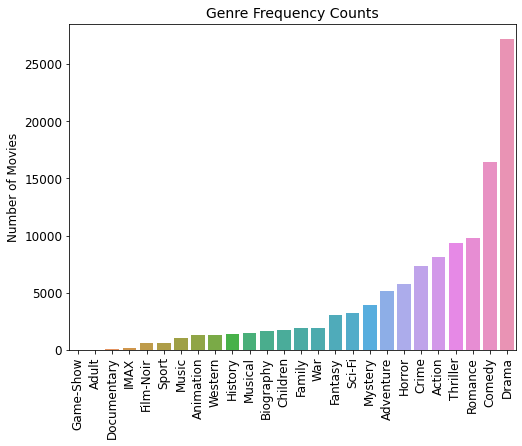

In [8]:
barplot(genre_counts, 'genres', 'cnt', 'Genre Frequency Counts', 'Number of Movies')

__Most Common Genre Combinations__

In [9]:
# convert list to tuple so hashable
df.genres_all = df.genres_all.apply(tuple)

# count by unique genre combination (verified lists internally sorted the same)
genre_combos = df.groupby('genres_all').movieId.count().to_frame()
genre_combos.columns = ['cnt']

# take top 10 most popular
genre_combos = genre_combos.sort_values('cnt').tail(10)

# clean index string 
genre_combos.index = genre_combos.index.map(str)
genre_combos['lst'] = genre_combos.index
genre_combos.lst = genre_combos.lst.str.replace('(', '').str.replace(')', '').str.replace(',', '')

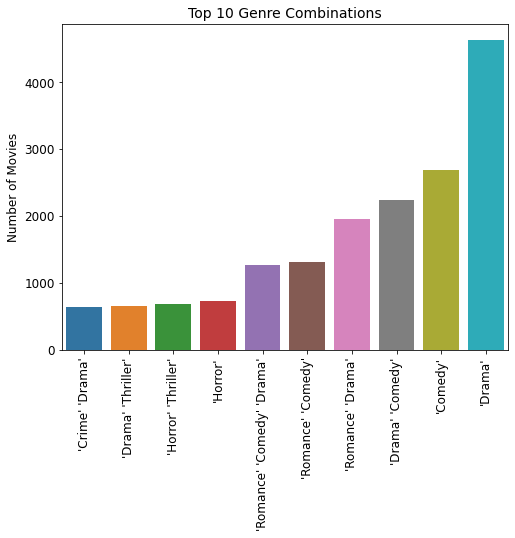

In [10]:
barplot(genre_combos, 'lst', 'cnt', 'Top 10 Genre Combinations', 'Number of Movies')

__Frequency of Movies by Year__

In [11]:
movies_yr = df.groupby('year').movieId.count().to_frame()

Text(0.5, 1.0, 'Release Year Frequency Counts')

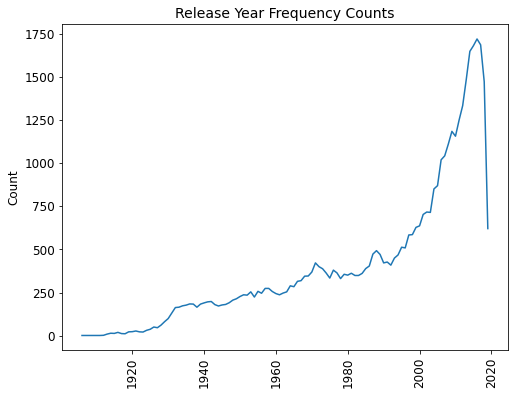

In [12]:
fig, ax = plt.subplots(figsize = (8,6))
sns.lineplot(movies_yr.index, movies_yr.movieId)
plt.xticks(rotation='vertical', size = 12)
plt.yticks(size = 12)

ax.set_xlabel('')
ax.set_ylabel('Count', size = 12)
ax.set_title('Release Year Frequency Counts', size = 14)

__Number of Movies by Filming Country__

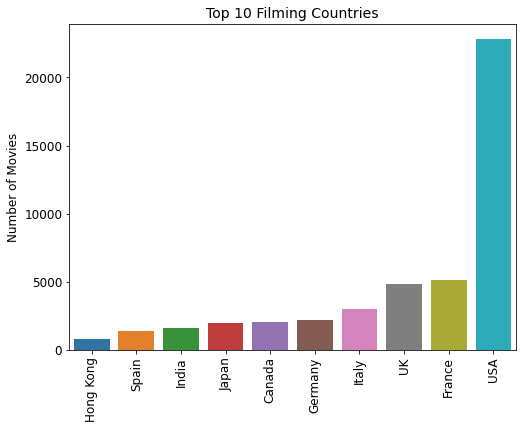

In [13]:
barplot(country_counts.tail(10), 'country', 'cnt', 'Top 10 Filming Countries', 'Number of Movies')

__Most Common Actors__

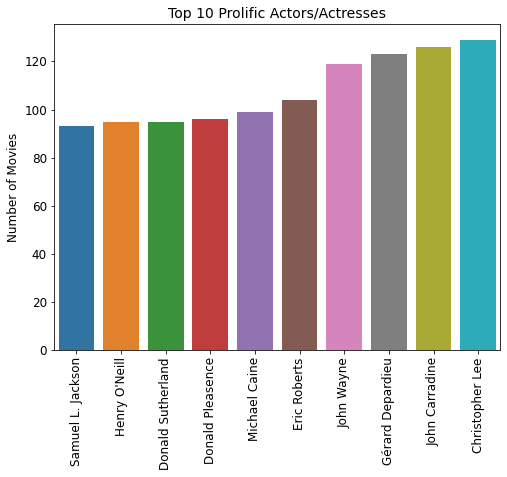

In [14]:
barplot(actors_counts.tail(10), 'actors', 'cnt', 'Top 10 Prolific Actors/Actresses', 'Number of Movies')

__Most Common Directors__

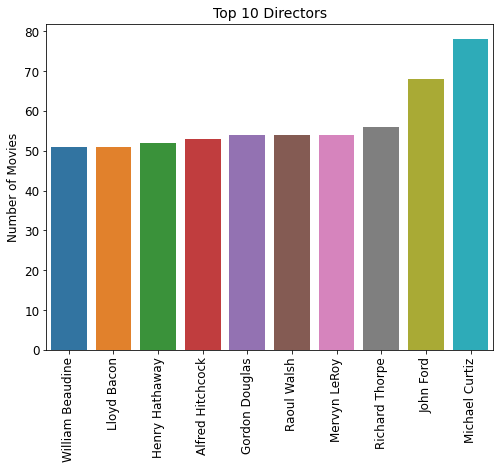

In [15]:
barplot(directors_counts.tail(10), 'director', 'cnt', 'Top 10 Directors', 'Number of Movies')

__Most Common Production Companies__

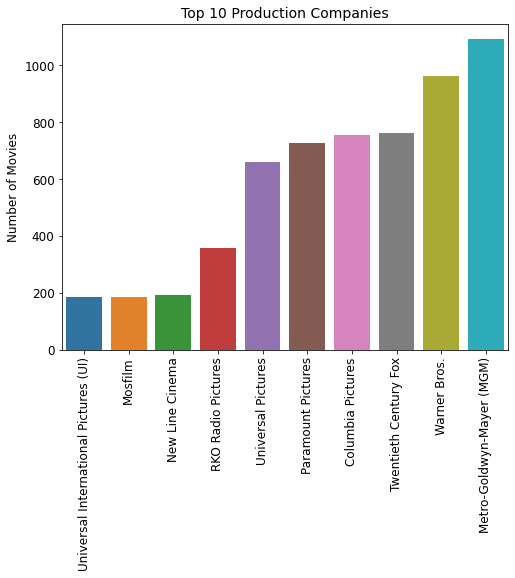

In [16]:
barplot(prod_counts.tail(10), 'production_company', 'cnt', 'Top 10 Production Companies', 'Number of Movies')

__Most Frequent Description Tokens__

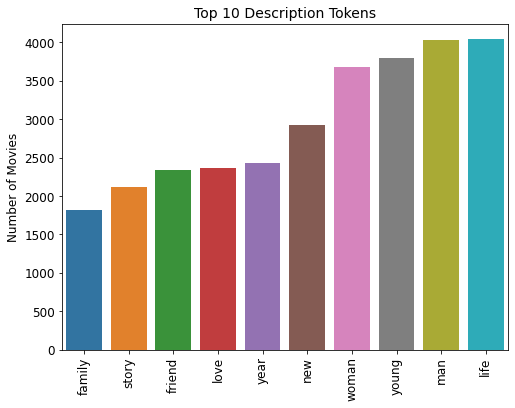

In [17]:
barplot(desc_counts.tail(10), 'desc', 'cnt', 'Top 10 Description Tokens', 'Number of Movies')

### Genome Tags

__Distribution of Tag Relevance__    
Most tags have low relevance for most movies      
Using 75% as cutoff for relevance in project: gets a selective group of tags for each movie

Text(0.5, 1.0, 'Distribution of Tag Relevance Scores')

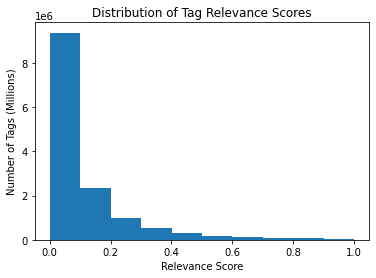

In [18]:
plt.hist(tags.relevance)
plt.xlabel('Relevance Score')
plt.ylabel('Number of Tags (Millions)')
plt.title('Distribution of Tag Relevance Scores')

__Most Common Genome Tags__

In [19]:
# limit to tags that have over 50% relevance for a movie
relevant_tags = tags[tags.relevance > 0.5]

In [20]:
tag_count = relevant_tags.groupby('tag').movieId.count().to_frame()
tag_count.columns = ['cnt']
tag_count['tag'] = tag_count.index
tag_count = tag_count.sort_values('cnt')

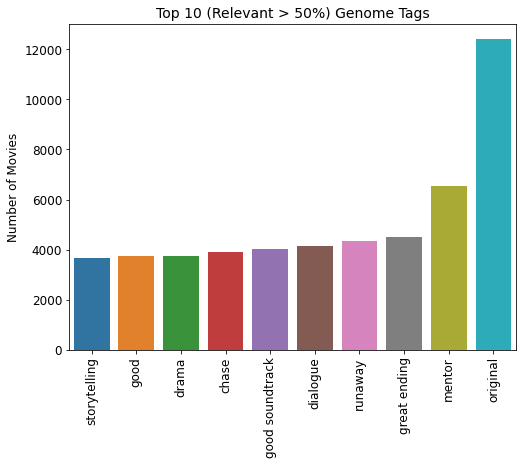

In [21]:
barplot(tag_count.tail(10), 'tag', 'cnt', 'Top 10 (Relevant > 50%) Genome Tags', 'Number of Movies')

__Number of Tags per Movie__    
When we filter, how much can we expect to return for each tag?   

In [22]:
tag_movies = relevant_tags.groupby('movieId').tag.count().to_frame()
tag_movies.columns = ['cnt']
tag_movies['movie'] = tag_movies.index
tag_movies = tag_movies.sort_values('cnt')

Text(0.5, 1.0, 'Distribution of Number of Tags per Movie')

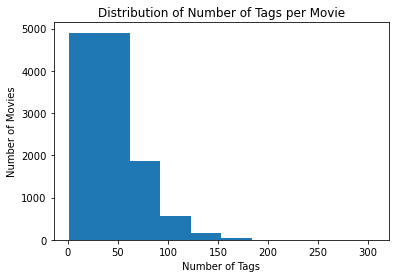

In [23]:
plt.hist(tag_movies.cnt)
plt.xlabel('Number of Tags')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number of Tags per Movie')

## Ratings Data

__Frequency of Year of Review__: Do we have older reviews that should be downweighted?

In [24]:
# convert timestamp to date variable
ratings['date'] =  ratings.timestamp.apply(lambda row: datetime.datetime.fromtimestamp(row))
ratings['year'] = ratings.date.dt.year

# count number of ratings per year
ratings_year = ratings.groupby('year').rating.count().to_frame()
ratings_year.columns = ['cnt']
ratings_year['year'] = ratings_year.index

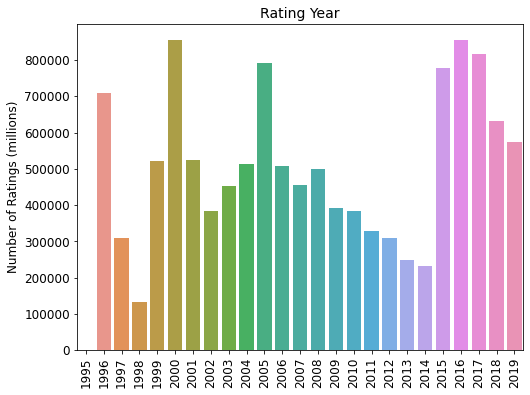

In [25]:
barplot(ratings_year, 'year', 'cnt', 'Rating Year', 'Number of Ratings (millions)')

__Distribution of Number of Ratings by Movie__: How much of a long tail do we have of less popular movies?    
Lots of movies with only a few ratings (<10)

Text(0.5, 1.0, 'Distribution of Number Ratings by Movie:\n Many "Unpopular" Movies')

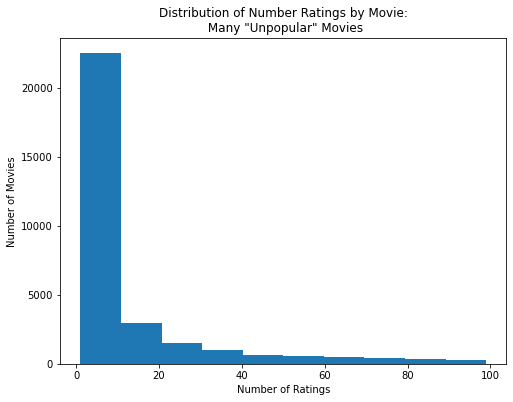

In [26]:
fig, ax = plt.subplots(figsize = (8,6))
ratings_movie = ratings.groupby('movieId').rating.count().to_frame()
plt.hist(ratings_movie[ratings_movie.rating < 100].rating)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number Ratings by Movie:\n Many "Unpopular" Movies') 

In [27]:
# How many movies with zero ratings? Would not be able to access these at all with collab filtering
len(df[~df.movieId.isin(ratings.movieId.unique())])

6822

In [28]:
# percent of movies with fewer than 10 ratings (if have at least 1 rating)
len(ratings_movie[ratings_movie.rating < 10]) / len(ratings_movie)

0.5754235291037155

__Distribution of Ratings__: more positive or more negative ratings?    
Skewed towards positive ratings -- good for our purposes, don't care much about low ratings     
Important to normalize ratings

Text(0.5, 1.0, 'Distribution of Ratings')

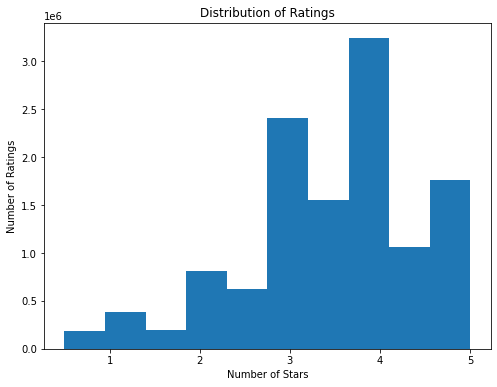

In [29]:
fig, ax = plt.subplots(figsize = (8,6))
plt.hist(ratings.rating)
plt.xlabel('Number of Stars')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Ratings')

## Most Highly Rated 
Two versions: 
1. Top average rating if > 100 ratings 
    - Based on ratings of movies with > 100 ratings
2. Weighted average between average rating and count
    - Based on ratings on all movies 

If just sort by average rating, get lots of 5 star movies that have only been rated once or twice

__Function to calculate highest rated__


In [30]:
def most_highly_rated(df, var, movie_ratings, expand = True):
    
    if expand: 
        # expand: one value per row
        expanded = cat_list_expand(df, var)
    else:
        expanded = df.copy()

    # merge with movie rating data: get average rating and rating count of each movie each actor has been in
    # excludes movies with fewer than 100 ratings: shouldn't take average of average based on these
    ratings = pd.merge(expanded, movie_ratings, on = 'movieId')
    # aggregate by var
    ratings = ratings.groupby(var).agg({'avg':'mean', 'cnt':'sum'})
    ratings[var.split('_lst')[0]] = ratings.index
    ratings = ratings.sort_values('avg')
    
    return ratings

__Movies__

(0.0, 5.0)

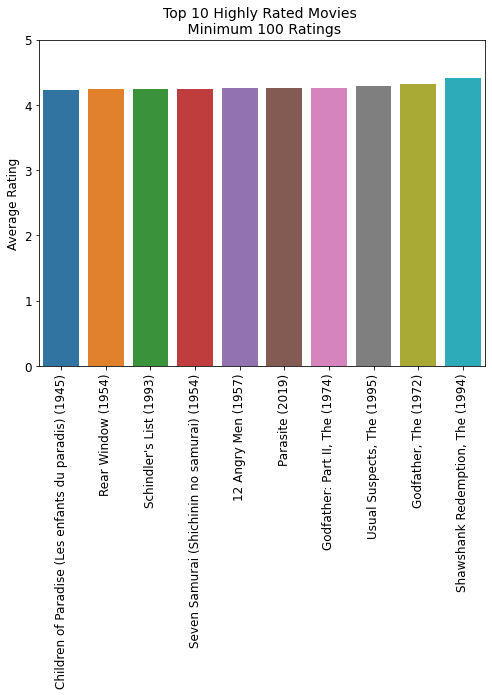

In [31]:
# exclude if fewer than 100 ratings
movie_ratings_100 = movie_ratings[movie_ratings.cnt >= 100]

# plot
ax = barplot(movie_ratings_100.tail(10), 'title_eng', 'avg',
             'Top 10 Highly Rated Movies \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated movies: Weighted Average__

In [32]:
movie_ratings['weighted_avg'] = movie_ratings.avg * movie_ratings.cnt
movie_ratings = movie_ratings.sort_values('weighted_avg')

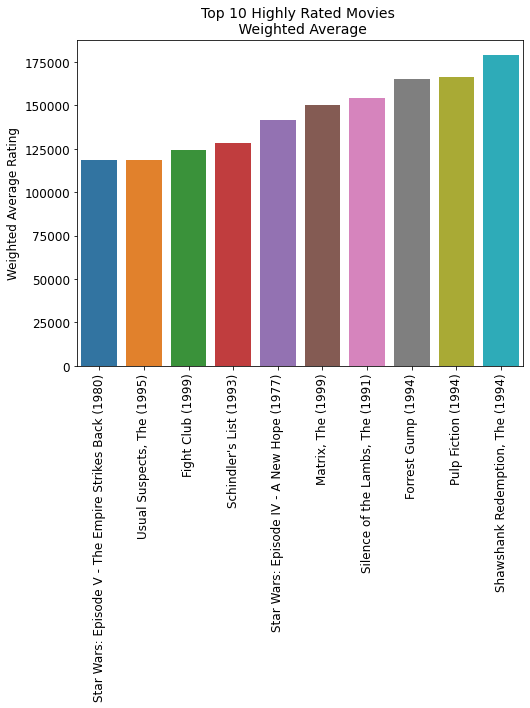

In [33]:
# plot
ax = barplot(movie_ratings.tail(10), 'title_eng', 'weighted_avg', 'Top 10 Highly Rated Movies \n Weighted Average', 
             'Weighted Average Rating')

__Most highly rated actors__    
Average scores of all movies they are in 

In [34]:
actors_rating = most_highly_rated(df, 'actors_lst', movie_ratings_100)

(0.0, 5.0)

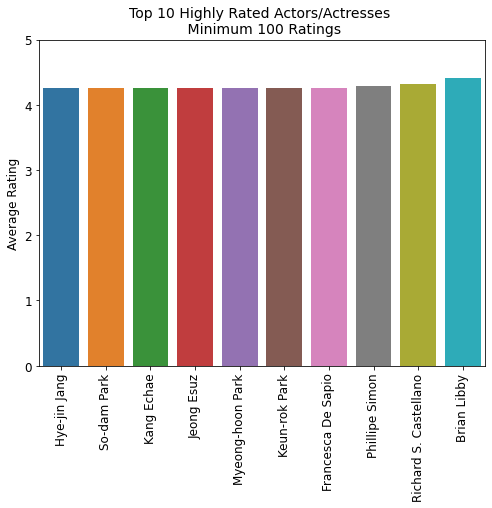

In [35]:
# exclude if in total movies with less than 100 ratings
actors_rating_100 = actors_rating[actors_rating.cnt >= 100]

ax = barplot(actors_rating_100.tail(10), 'actors', 'avg', 
             'Top 10 Highly Rated Actors/Actresses \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated actors: Weighted Average__

In [36]:
actors_rating = most_highly_rated(df, 'actors_lst', movie_ratings)

actors_rating['weighted_avg'] = actors_rating.avg * actors_rating.cnt
actors_rating = actors_rating.sort_values('weighted_avg')

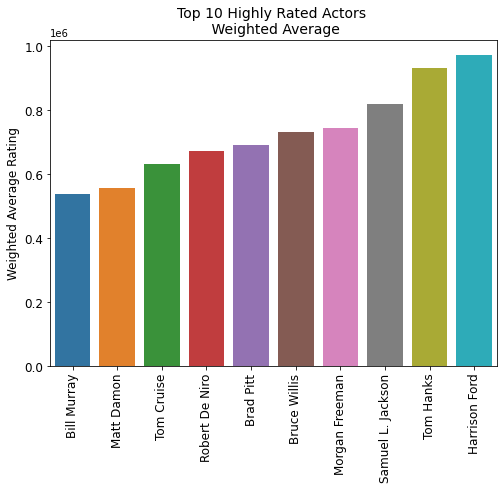

In [37]:
# plot
ax = barplot(actors_rating.tail(10), 'actors', 'weighted_avg',
             'Top 10 Highly Rated Actors \n Weighted Average', 'Weighted Average Rating')

__Most highly rated directors__

In [38]:
director_rating = most_highly_rated(df, 'director_lst', movie_ratings_100)

(0.0, 5.0)

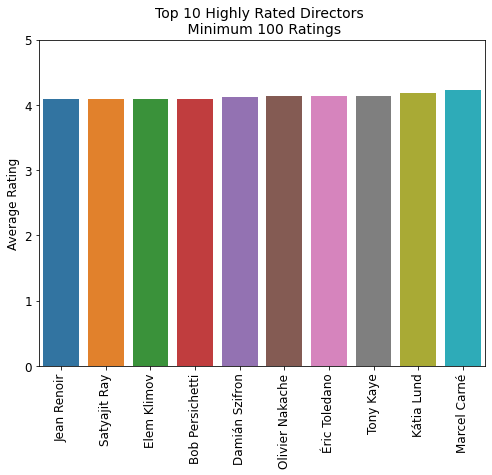

In [39]:
# exclude if in total movies with less than 100 ratings
director_rating_100 = director_rating[director_rating.cnt >= 100]

ax = barplot(director_rating_100.tail(10), 'director', 'avg',
             'Top 10 Highly Rated Directors \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated directors: Weighted Average__

In [40]:
director_rating = most_highly_rated(df, 'director_lst', movie_ratings)

director_rating['weighted_avg'] = director_rating.avg * director_rating.cnt
director_rating = director_rating.sort_values('weighted_avg')

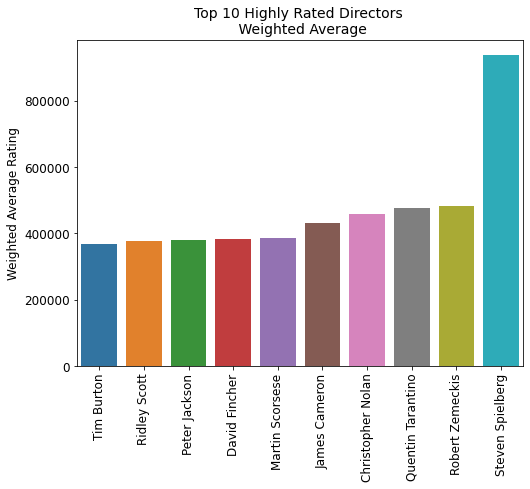

In [41]:
# plot
ax = barplot(director_rating.tail(10), 'director', 'weighted_avg',
             'Top 10 Highly Rated Directors \n Weighted Average', 'Weighted Average Rating')

__Most highly rated genres__

In [42]:
genre_rating = most_highly_rated(df, 'genres_all', movie_ratings_100)

(0.0, 5.0)

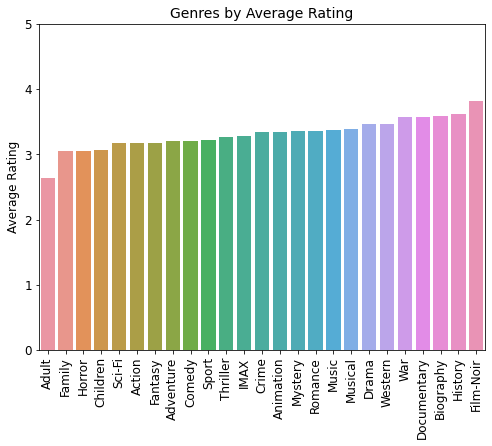

In [43]:
ax = barplot(genre_rating, 'genres_all', 'avg',
             'Genres by Average Rating', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated directors: Weighted Average__

In [44]:
genre_rating = most_highly_rated(df, 'genres_all', movie_ratings)

genre_rating['weighted_avg'] = genre_rating.avg * genre_rating.cnt
genre_rating = genre_rating.sort_values('weighted_avg')

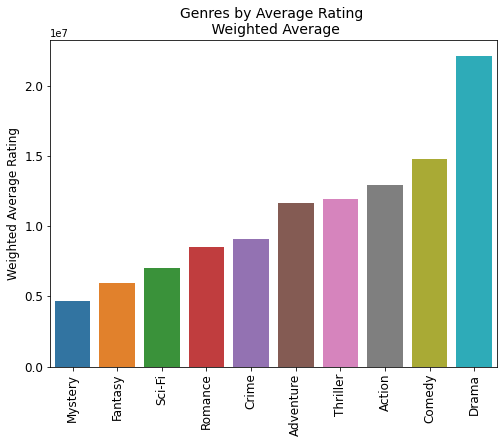

In [45]:
# plot
ax = barplot(genre_rating.tail(10), 'genres_all', 'weighted_avg',
             'Genres by Average Rating \n Weighted Average', 'Weighted Average Rating')

__Most highly rated production companies__

In [46]:
prod_rating = most_highly_rated(df, 'production_company', movie_ratings_100, expand = False)

(0.0, 5.0)

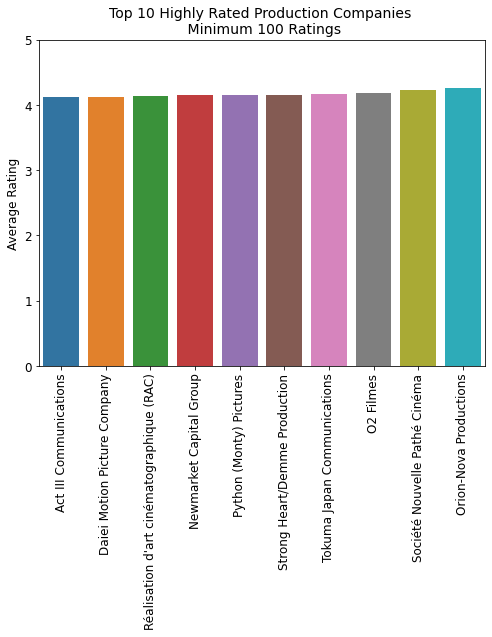

In [47]:
# exclude if in total movies with less than 100 ratings
prod_rating = prod_rating[prod_rating.cnt >= 100]

ax = barplot(prod_rating.tail(10), 'production_company', 'avg',
             'Top 10 Highly Rated Production Companies \n Minimum 100 Ratings', 'Average Rating')
ax.set_ylim(0,5)

__Most highly rated production companies: Weighted Average__

In [48]:
prod_rating = most_highly_rated(df, 'production_company', movie_ratings, expand = False)

prod_rating['weighted_avg'] = prod_rating.avg * prod_rating.cnt
prod_rating = prod_rating.sort_values('weighted_avg')

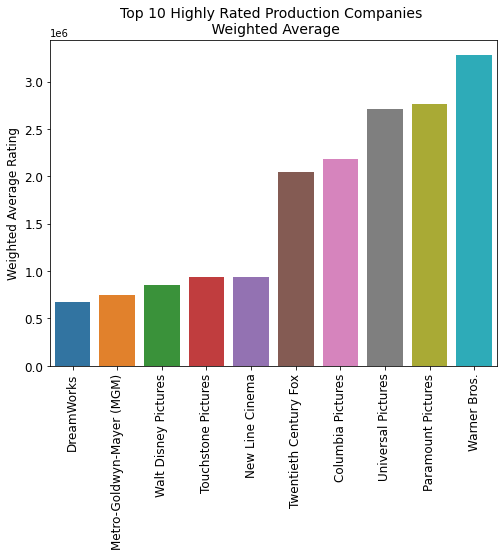

In [49]:
# plot
ax = barplot(prod_rating.tail(10), 'production_company', 'weighted_avg',
             'Top 10 Highly Rated Production Companies \n Weighted Average', 'Weighted Average Rating')

__Rating by decade__

In [50]:
decade_rating = most_highly_rated(df, 'decade', movie_ratings_100, expand = False)

[Text(0, 0, '1990'),
 Text(0, 0, '1980'),
 Text(0, 0, '2000'),
 Text(0, 0, '1910'),
 Text(0, 0, '2010'),
 Text(0, 0, '1970'),
 Text(0, 0, '1960'),
 Text(0, 0, '1950'),
 Text(0, 0, '1940'),
 Text(0, 0, '1930'),
 Text(0, 0, '1920')]

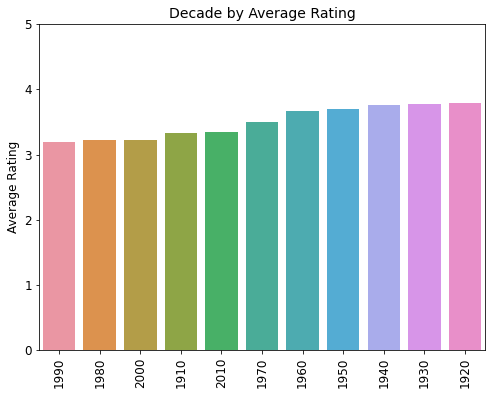

In [51]:
fig, ax = plt.subplots(figsize = (8,6))
sns.barplot(np.arange(len(decade_rating.decade)), decade_rating.avg)
plt.xticks(rotation='vertical', size = 12)
plt.yticks(size = 12)

ax.set_xlabel('')
ax.set_ylabel('Average Rating', size = 12)
ax.set_title('Decade by Average Rating', size = 14)

ax.set_ylim(0,5)
ax.set_xticklabels(decade_rating.decade)

__Weighted Average by Decade__

In [52]:
decade_rating = most_highly_rated(df, 'decade', movie_ratings, expand = False)

decade_rating['weighted_avg'] = decade_rating.avg * decade_rating.cnt
decade_rating = decade_rating.sort_values('weighted_avg')

[Text(0, 0, '1910'),
 Text(0, 0, '1920'),
 Text(0, 0, '1930'),
 Text(0, 0, '1940'),
 Text(0, 0, '1950'),
 Text(0, 0, '1960'),
 Text(0, 0, '1970'),
 Text(0, 0, '2010'),
 Text(0, 0, '1980'),
 Text(0, 0, '2000'),
 Text(0, 0, '1990')]

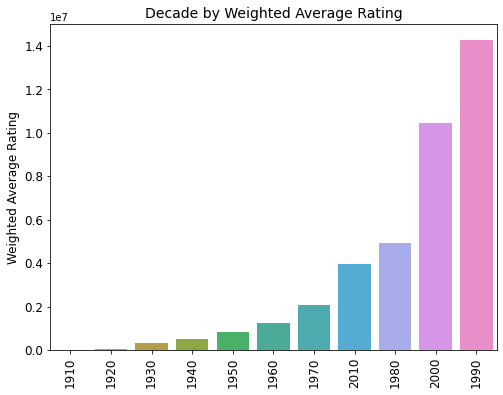

In [54]:
fig, ax = plt.subplots(figsize = (8,6))
sns.barplot(np.arange(len(decade_rating.decade)), decade_rating.weighted_avg)
plt.xticks(rotation='vertical', size = 12)
plt.yticks(size = 12)

ax.set_xlabel('')
ax.set_ylabel('Weighted Average Rating', size = 12)
ax.set_title('Decade by Weighted Average Rating', size = 14)

ax.set_xticklabels(decade_rating.decade)

## Distributions of Rating Counts by if movie has geome tags
Tags heavily biased towards popular movies

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000.]),
 <a list of 9 Text major ticklabel objects>)

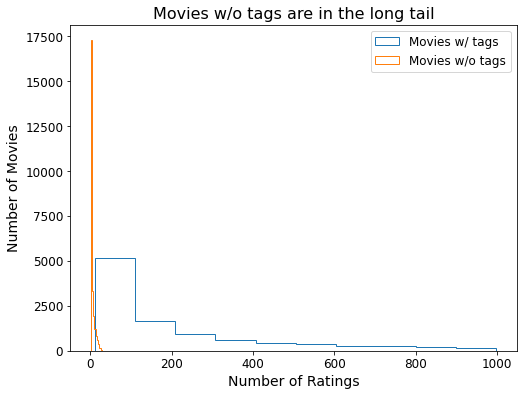

In [55]:
ax, fig = plt.subplots(figsize = (8,6))
tagged_movies = tags.movieId.unique()
plt.hist(movie_ratings[(movie_ratings.movieId.isin(tagged_movies)) & (movie_ratings.cnt < 1000)].cnt, 
         label = 'Movies w/ tags', histtype = 'step')
plt.hist(movie_ratings[(~movie_ratings.movieId.isin(tagged_movies)) & (movie_ratings.cnt < 1000)].cnt,
         label = 'Movies w/o tags', histtype = 'step')
plt.legend(prop={'size': 12})
plt.title('Movies w/o tags are in the long tail', size = 16)
plt.ylabel('Number of Movies', size = 14)
plt.xlabel('Number of Ratings', size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)